Andy Nguyen, Michael Wolfe, Spencer Fogelman, & Joseph Caguioa

DS 7331.407

Thursday 6:30pm - 8:00pm

# Logistic Regression and SVMs of AirBnB Data

### Instructions
[50 Points]
* Assess performance of each model using 80/20 training-test split
* Adjust model parameters to optimize accuracy
    * if dataset size requires stochastic gradient descent, then only linear kernel is appropriate
    
[10 Points]
* Discuss advantages of each model for each classification task
* Does one type of model offer superior performance over another in terms of prediction accuracy?
    * In terms of training time or efficiency? Explain.

[30 points]
* Use weights from logistic regression to interpret importance of different features for each classification task. Explain interpretation in detail.
    * Why do you think some variables are more important?
    
[10 points]
* Look at the chosen support vectors for the classifcation task. Do these provide any insight into the data? Explain.

## Introduction

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

This Kaggle dataset contains data on Airbnb listings for six major U.S. cities. The competition's original goal was to use available attributes to predict listing price. However, the inherent richness of the variables also allows

Airbnb Superhosts are experienced property owners who guests have helped rate as the best of the best. Earning this designation requires obtaining a minimum number of yearly stays, maintaining a high response rate, keeping above a certain score average, and avoiding cancellations. However, is it possible to predict Superhost status off of other attributes on the listing? For simplicity we define a Superhost as someone with a score average greater than or equal to 96%.

**Setup**

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
#import plotly.graph_objects as go
import datetime
import csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv('https://raw.githubusercontent.com/anguyen-07/DS7331-ML_Labs/master/data/airbnb_train.csv')
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])
df.dtypes

id                           int64
log_price                  float64
property_type               object
room_type                   object
amenities                   object
accommodates                 int64
bathrooms                  float64
bed_type                    object
cancellation_policy         object
cleaning_fee                  bool
city                        object
description                 object
first_review                object
host_has_profile_pic        object
host_identity_verified      object
host_response_rate          object
host_since                  object
instant_bookable            object
last_review                 object
latitude                   float64
longitude                  float64
name                        object
neighbourhood               object
number_of_reviews            int64
review_scores_rating       float64
thumbnail_url               object
zipcode                     object
bedrooms                   float64
beds                

The first step to preparing the Airbnb dataset for use with logistic regression and support vector machines is to remove or impute missing data and change the variables to compatible datatypes. Much of the logic behind this work was covered in Lab 1.

**Cleanup (from first project)**

In [42]:
##Clean up datatypes and duplicates
df_ratings = df.dropna(subset=['review_scores_rating'])
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')
df_ratings.drop_duplicates()
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

C:\Users\micha\Anaconda3\envs\ML1_env\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\micha\Anaconda3\envs\ML1_env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\micha\Anaconda3\envs\ML1_env\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org

In [43]:
# Impute missing values
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))
# Impute Missing Value of for 100% Host Response Rate for Row 48194 - Private Room in Apartment
df_imputed["host_response_rate"][df_imputed["host_response_rate"].isna()] = 1.0
df_imputed[ints] = df_imputed[ints].astype(np.int64)

C:\Users\micha\Anaconda3\envs\ML1_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\micha\Anaconda3\envs\ML1_env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\micha\Anaconda3\envs\ML1_env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a cop

Additionally, some of the existing attributes can be transformed into a potentially more useful datatype.

In [44]:
df_imputed['price'] = np.exp(df_imputed['log_price'])

C:\Users\micha\Anaconda3\envs\ML1_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
import re
#Create a new cleaned amenities column where all amenities are in list form
df_imputed['amenities_new'] = df_imputed.apply(lambda row: re.sub(r'[{}""]', '', row['amenities']), axis=1)
df_imputed['amenities_new'] = df_imputed.apply(lambda row: row['amenities_new'].lower().split(','), axis=1)
df_imputed = df_imputed.reset_index()
df_imputed['length_amenities'] = df_imputed.apply(lambda row: len(row['amenities_new']), axis=1)

# Create separate columns based on amenities
df_imputed['internet'] = df_imputed.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
df_imputed['TV'] = df_imputed.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
df_imputed['air_conditioning'] = df_imputed.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
df_imputed['kitchen'] = df_imputed.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
df_imputed['pool'] = df_imputed.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
df_imputed['parking'] = df_imputed.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)

# Get information from description based on length in characters
df_imputed['description_length'] = df_imputed['description'].apply(len)

# Create the target variable superuser
df_imputed['superuser'] = False
df_imputed.loc[df.review_scores_rating >=96, 'superuser'] = True

C:\Users\micha\Anaconda3\envs\ML1_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\micha\Anaconda3\envs\ML1_env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [46]:
import datetime
date_published = datetime.datetime(2018,3,14)
df_imputed['host_since'] = pd.to_datetime(df_imputed['host_since'])
df_imputed['host_since_days'] = df_imputed.apply(lambda row: (date_published - row['host_since']).days, axis=1)

Columns that are not meaningful in a modeling context (e.g., index, id), redundant with newly engineered features (e.g., amenities, description), or likely not useful in predicting the target variable superuser (e.g., zipcode, thumbnail_url) are removed. 

In [47]:
# delete useless columns
df_logistic = df_imputed.drop(['index', 'id', 'log_price', 'amenities', 'description', 'zipcode', 'description',
                      'latitude', 'longitude', 'name', 'neighbourhood', 'review_scores_rating',
                      'thumbnail_url', 'zipcode'], axis=1)

# Delete other redundant variables
del df_logistic['amenities_new']
del df_logistic['host_since']
del df_logistic['grade']
del df_logistic['first_review']
del df_logistic['last_review']

In [48]:
categorical_vars = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']
df_logistic[categorical_vars].apply(lambda x: len(x.value_counts()), axis=0)

property_type          32
room_type               3
bed_type                5
cancellation_policy     5
city                    6
dtype: int64

In [49]:
# Remove factor with unnecessarily large number of levels
df_logistic.drop(['property_type'], axis=1, inplace=True)

In [50]:
df_logistic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 25 columns):
room_type                 57389 non-null category
accommodates              57389 non-null int64
bathrooms                 57389 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        57389 non-null float64
instant_bookable          57389 non-null bool
number_of_reviews         57389 non-null int64
bedrooms                  57389 non-null int64
beds                      57389 non-null int64
price                     57389 non-null float64
length_amenities          57389 non-null int64
internet                  57389 non-null bool
TV                        57389 non-null bool
air_conditioning          57389 n

#### Checking Class Imbalances & Collinearity

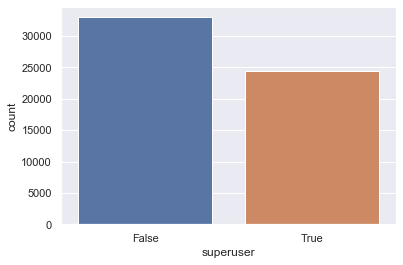

In [51]:
sns.countplot(data=df_logistic, x='superuser')

A simple bar chart of the counts shows that both classes of Superuser, the target variable, are well-represented in the remaining data.

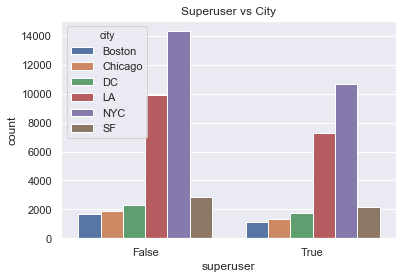

In [52]:
sns.countplot(data=df_logistic, x='superuser', hue='city')
plt.title('Superuser vs City')
plt.show()

One of the multi-level categorical variables retained in building the models, city, doesn't appear to have major imbalances when accounting for Superuser status. It is worth noting that New York City and Los Angeles are more strongly represented than the other four.

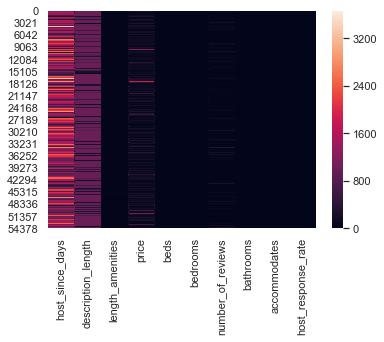

In [53]:
numerical_features = ['host_since_days', 'description_length', 'length_amenities', 'price', 'beds',
                     'bedrooms', 'number_of_reviews', 'bathrooms', 'accommodates', 'host_response_rate']
sns.heatmap(df_logistic[numerical_features])

Collinearity does not appear to be a concern based on the numeric variables. However, it is worth noting that there are vast scaling differences. For example, host_since_days counts the number of days a listing existed until a given date, resulting in a mean in the thousands because many listings have been active for several years. In contrast, host_response_rate is a percentage. Standardizing these values to account for this may be useful, and is explored later on.

In [54]:
# Create dummy variables
multiCategorical_vars = ['city', 'cancellation_policy','bed_type', 'room_type']

dummy_df = pd.get_dummies(df_logistic[multiCategorical_vars], drop_first=True)
df_logistic_dummy = pd.concat([df_logistic, dummy_df], axis=1)

# Delete non-dummy categorical variables
for x in categorical_vars:
    if x in df_logistic_dummy:
        del df_logistic_dummy[x]

df_logistic_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 36 columns):
accommodates                           57389 non-null int64
bathrooms                              57389 non-null float64
cleaning_fee                           57389 non-null bool
host_has_profile_pic                   57389 non-null bool
host_identity_verified                 57389 non-null bool
host_response_rate                     57389 non-null float64
instant_bookable                       57389 non-null bool
number_of_reviews                      57389 non-null int64
bedrooms                               57389 non-null int64
beds                                   57389 non-null int64
price                                  57389 non-null float64
length_amenities                       57389 non-null int64
internet                               57389 non-null bool
TV                                     57389 non-null bool
air_conditioning                       57389 non-nu

### Training/Test Data Split

In [55]:
y = df_logistic_dummy['superuser'].values
X = df_logistic_dummy.drop(['superuser'], axis=1).values

In [56]:
from sklearn.model_selection import ShuffleSplit
# Use X to predict the binary class of y
## X and Y are numpy matricies - .values call converts the data type to simple matrices
if 'superuser' in df_logistic_dummy:
    y = df_logistic_dummy['superuser'].values # retrieve binary value for class distinction
    del df_logistic_dummy['superuser'] # get rid of True/False label
    X = df_logistic_dummy.values # use all other attribute values to predict
    
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                        test_size = 0.2,
                        random_state = 123) # set random number seed
cv_object

ShuffleSplit(n_splits=10, random_state=123, test_size=0.2, train_size=None)

## Create Models

### Logistic Regression Model

#### Without Scaling

In [57]:
##Basic model, all numeric data
#x_train, x_test, y_train, y_test = train_test_split(df_imputed.loc[:,['log_price','accommodates','bathrooms','number_of_reviews','review_scores_rating','bedrooms','beds']]
#                                                    , df_imputed.loc[:,['grade']], test_size=0.2, random_state=0)
#LogisticRegression().fit(x_train,y_train).predict(x_test[0].reshape(1,-1))


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

#create logistic regression object
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object


In [59]:
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
accuracies

array([0.57727827, 0.56961143, 0.57727827, 0.57022129, 0.57257362,
       0.57074403, 0.57091828, 0.57631992, 0.57152814, 0.57501307])

#### With Scaling

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import statistics

In [61]:
std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this
#Pipeline takes in a list of tuples, where each tuple is (object name, object)

In [62]:
%%time
weights = []
accuracy_average = []
recall_average = []
precision_average = []
f1_average = []

# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    piped_object.fit(X_train, y_train)  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
    y_hat = piped_object.predict(X_test)
    acc_iter = mt.accuracy_score(y_test, y_hat)
    rec_iter = mt.recall_score(y_test, y_hat)
    pre_iter = mt.precision_score(y_test, y_hat)
    f1_iter = mt.f1_score(y_test, y_hat)
    conf_iter = mt.confusion_matrix(y_test, y_hat)
    
    accuracy_average.append(acc_iter)
    recall_average.append(rec_iter)
    precision_average.append(pre_iter)
    f1_average.append(f1_iter)
    
    print("#### Iteration", iter_num, "####")
    print("accuracy:", acc_iter)
    print("recall:", rec_iter)
    print("precision:", pre_iter)
    print("f1 score:", f1_iter)
    print("confusion matrix:\n", conf_iter)

weights = np.array(weights)
print("#### 10-Fold Averages ####")
print("average accuracy:", statistics.mean(accuracy_average))
print("average recall:", statistics.mean(recall_average))
print("average precision:", statistics.mean(precision_average))
print("average f1 score:", statistics.mean(f1_average))

#### Iteration 0 ####
accuracy: 0.5777138874368357
recall: 0.0026793075020610057
precision: 0.6190476190476191
f1 score: 0.005335522265544839
confusion matrix:
 [[6618    8]
 [4839   13]]
#### Iteration 1 ####
accuracy: 0.5696114305628158
recall: 0.0024291497975708503
precision: 0.5
f1 score: 0.004834810636583401
confusion matrix:
 [[6526   12]
 [4928   12]]
#### Iteration 2 ####
accuracy: 0.5772782714758669
recall: 0.0030915086562242375
precision: 0.5
f1 score: 0.0061450225317492835
confusion matrix:
 [[6611   15]
 [4837   15]]
#### Iteration 3 ####
accuracy: 0.5702212929081721
recall: 0.003851611595378066
precision: 0.5
f1 score: 0.007644337155501911
confusion matrix:
 [[6526   19]
 [4914   19]]
#### Iteration 4 ####
accuracy: 0.5722251263286287
recall: 0.003465144720750102
precision: 0.4473684210526316
f1 score: 0.006877022653721683
confusion matrix:
 [[6551   21]
 [4889   17]]
#### Iteration 5 ####
accuracy: 0.5709182784457223
recall: 0.0016237061091942358
precision: 0.571428571428

As shown by the confusion matrices, these models overwhelmingly label most postings as Superusers, resulting in almost all actual negatives being classified as false positives. Whether this bias towards precision is problematic depends on intangible costs. If guests stay at incorrectly labeled Superuser listings that don't meet expectations, that could dilute benefits associated with being a Superuser.

In [63]:
# # Attempt at parameter tuning

# pipe = Pipeline([('classifier', LogisticRegression())])

# parameter_grid = [
#     'classifier': [LogisticRegression()],
#     'classifier_penalty': ['l1', 'l2'],
#     'classifier_C': [0, 0.25, 0.50, 0.75, 1],
#     'classifier_solver': ['liblinear']
# ]

# clf = GridSearchCV(pipe, param_grid = parameter_grid, cv = 5, verbose = True, n_jobs = -1)
# best_clf = clf.fit(X)

### Interpretation of Feature Importance

<i>[30 points]
* Use weights from logistic regression to interpret importance of different features for each classification task. Explain interpretation in detail.
    * Why do you think some variables are more important?</i>

In [64]:
# Print out weights
zip_vars = zip(lr_clf.coef_.T, df_logistic_dummy.columns)
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has this weight:', coef[0])

number_of_reviews has this weight: -0.019871630738556363
bathrooms has this weight: -0.01968700309592428
cancellation_policy_super_strict_60 has this weight: -0.01810081169270709
kitchen has this weight: -0.00996930917062015
host_identity_verified has this weight: -0.006726682917146363
TV has this weight: -0.006668433642112774
internet has this weight: -0.006473531663955228
cleaning_fee has this weight: -0.006106716643825131
accommodates has this weight: -0.004128930299301477
cancellation_policy_strict has this weight: -0.0037469305996454946
cancellation_policy_super_strict_30 has this weight: -0.003239252963106692
room_type_Private room has this weight: -0.0030481585627293627
host_response_rate has this weight: -0.0029098064813543345
pool has this weight: -0.0009099723128678456
price has this weight: 0.001746043746437486
host_since_days has this weight: 0.0024565801032535328
bedrooms has this weight: 0.0030293273393239887
parking has this weight: 0.004133135260869091
host_has_profile_

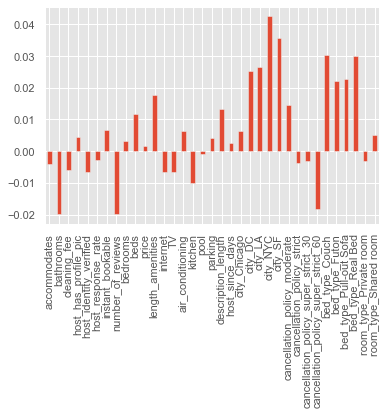

In [65]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0], df_logistic_dummy.columns)
weights.plot(kind='bar')
plt.show()

As mentioned before, average review score rating was the sole variable used to classify Superusers for this task, but cancellations are also involved in the true Airbnb designation. However, cancellation rate is not a variable in the dataset. Instead, a listing's cancellation policy--one of several levels--is included. Super strict 60 days, which requires that a guest cancel at least 60 days before check-in just to receive a 50% refund, is the strongest negatively weighted. In contrast, a moderate policy allows a full refund if a guest cancels at least two weeks before. Reasons as to why this occurs are speculative because guests who cancel should not be affecting score by leaving reviews (and on the flipside, guests who actually stay likely aren't affected by the cancellation policy), but perhaps a host's chosen policy reflects some qualities that translate to a guest's experience, with stricter cancellation policies being associated with hosts of more unsatisfying stays.

Of the included variables, number_of_reviews is one of the strongest negatively weighted variables for Superuser. It is highly likely that the more reviews a listing accrues, the greater the chances of people leaving negative reviews that tank the average score below our Superuser threshold. Whether through an off-day with a genuinely bad experience or a hard-to-please customer, simply having more reviews invites the possibility of a lower score because dissatisfied guests are often more likely to post negative reviews than satisfied guests with positive ones.

Both variables for character length about the property, description_length and length_amenities, have mild positive weights. It is possible that properties with lots of amenities available and detailed descriptions about a property's attributes that aren't captured cleanly in the regular amenities checklist (such as proximity to areas of interest) allow guests to make well-informed decisions to their own needs, which would translate to good stays and five-star reviews.

The number of bathrooms and number of guests that can be accommodated both have negative weights, yet the number of bedrooms and beds have positive ones. These four should all trend together, as a bigger property that can accommodate more guests will likely have more bedrooms, bathrooms, and beds available. Thus, the divide on the weights here is difficult to explain.

The represented cities all have positive weights for Superuser. New York City and San Francisco have the biggest weights, though not by much. While New York City could have been expected due to being the most represented in the data (as seen in an earlier histogram), San Francisco trailed in representation at a distant third. Second-place represented Los Angeles, meanwhile, has a weight value comparable to Washington DC. 

All bed types shown have positive weights for Superuser. Couch and real bed appear to have similar weights, both greater than pull-out sofa and futon. One might assume that a real bed, the generally most comfortable option enabling better sleep, would have the greatest weight, but this is not the case. Perhaps the relative comfort of the bed type is not a major factor for review scores, so long as the guest has an actual surface to sleep on?

Room type has another unusual result, with shared room having more weight than a private room. In shared rooms, guests sleep and share the property with other guests potentially not of their party (similarly to a hostel). It could be that the extra social connection beyond the local host adds to a guest's experience, resulting in higher scores.

In [66]:
# error_y=dict(
#             type='data',
#             array=np.std(weights,axis=0),
#             visible=True
#         )
# error_y

In [67]:
# graph1 = {'x': df_logistic_dummy.columns,
#           'y': np.mean(weights,axis=0),
#     'error_y':error_y,
#        'type': 'bar'}
# graph1

In [68]:
# fig = dict()
# fig['data'] = [graph1]
# fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

# plotly.offline.iplot(fig)

### Support Vector Machine Model

C:\Users\micha\Anaconda3\envs\ML1_env\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\micha\Anaconda3\envs\ML1_env\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


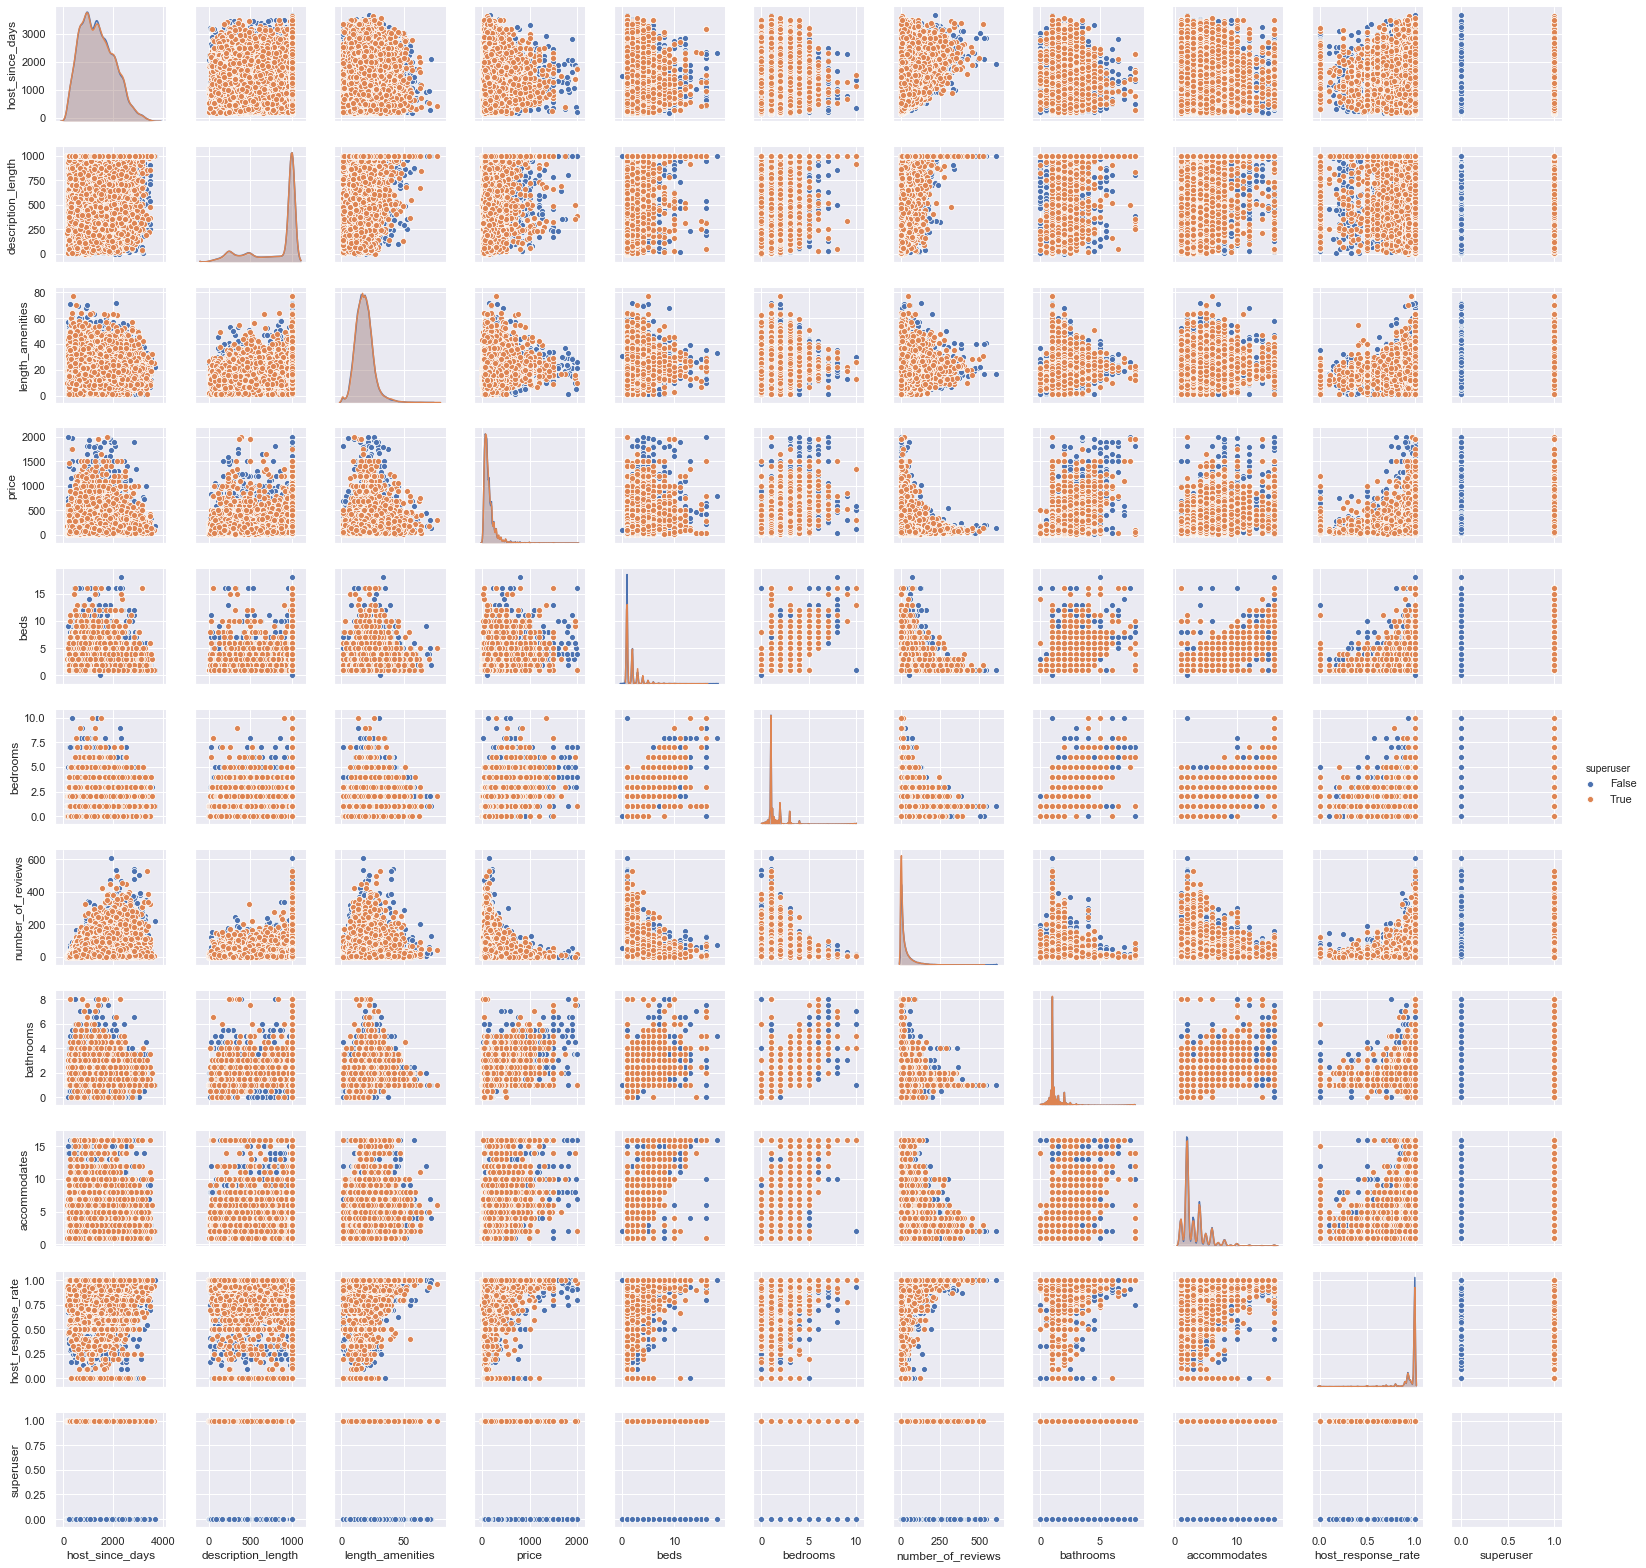

In [69]:
# Check if Numerical Features can linearly separate Superuser/Non-Superuser
%matplotlib inline
sns.set()
df_logistic_dummy['superuser'] = y
df_linear_sep = pd.concat([df_logistic_dummy[numerical_features], df_logistic_dummy['superuser']],axis = 1)
sns.pairplot(df_linear_sep, hue = 'superuser', height = 2)

In [70]:
# Run through the cross-validation loop object previously set-up
## Training and Test data should be set for one single interation
for train_indicies, test_indicies in cv_object.split(X,y):
    X_train = X[train_indicies]
    y_train = y[train_indicies]
    
    X_test = X[test_indicies]
    y_test = y[test_indicies]
    
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

In [71]:
from sklearn.svm import SVC
from sklearn import metrics as mt

# Create SVM training object
svm_clf_lin = SVC(C = 1.0, kernel = 'linear', degree = 3, gamma = 'auto', random_state = 123)
# Train the SVM model
svm_clf_lin.fit(X_train_scaled, y_train)
# Predict based on trained model - y_hat = model predictions
y_hat_lin = svm_clf_lin.predict(X_test_scaled)

acc = mt.accuracy_score(y_test,y_hat_lin)
conf = mt.confusion_matrix(y_test,y_hat_lin)
print('SVM Model Accuracy Linear Kernel)', acc)
print(conf)

SVM Model Accuracy Linear Kernel) 0.5748388220944416
[[6584   16]
 [4864   14]]


In [72]:
# Change penalty tuning parameter from 1.0 to 0.0001
svm_clf_adjLin = SVC(C = 0.0001, kernel = 'linear', degree = 3, gamma = 'auto', random_state = 123)
svm_clf_adjLin.fit(X_train_scaled, y_train)
y_hat_adjLin = svm_clf_adjLin.predict(X_test_scaled)

acc_adjLin = mt.accuracy_score(y_test,y_hat_adjLin)
conf_adjLin = mt.confusion_matrix(y_test,y_hat_adjLin)
print('SVM Model Accuracy (Adjusted Linear Kernel)', acc_adjLin)
print(conf_adjLin)

print('Linear coefficients are ', svm_clf_adjLin.coef_)
print('Intercept is ',svm_clf_adjLin.intercept_)

SVM Model Accuracy (Adjusted Linear Kernel) 0.575013068478829
[[6600    0]
 [4878    0]]
Linear coefficients are  [[ 7.69705890e-06 -2.37148191e-06 -1.54373004e-06 -4.82123022e-15
   2.75294682e-07  5.19204577e-07  1.48267266e-06 -7.40544336e-06
  -1.16850080e-06  3.32577537e-06  4.18470599e-06 -9.00360114e-07
  -4.77656109e-15  3.50325949e-06  2.97018500e-07  5.00186854e-06
  -2.60473700e-06 -1.03109157e-06  4.68400612e-06  9.58250965e-07
  -6.53475937e-06 -5.35237833e-06 -1.90613891e-05 -1.07559823e-05
  -1.54088518e-05 -6.08343380e-07  5.14471668e-07  1.27979224e-15
   3.02469893e-07  1.32242959e-02 -6.90554081e-07  1.20864248e-06
   1.00355860e-07  1.30819185e-05  2.49135673e-06]]
Intercept is  [-0.99930225]


In [73]:
#Test SGD Kernel
from sklearn.linear_model import SGDClassifier
svm_sgd = SGDClassifier()
svm_sgd
svm_sgd.fit(X_train_scaled, y_train)
y_hat_sgd = svm_sgd.predict(X_test_scaled)
acc2 = mt.accuracy_score(y_test,y_hat_sgd)
conf2 = mt.confusion_matrix(y_test,y_hat_sgd)
print('SVM Model Accuracy (C supported kernel)', acc2)
print(conf2)

SVM Model Accuracy (C supported kernel) 0.5731834814427601
[[6544   56]
 [4843   35]]


Using a linear kernel and regualization parameter value of 1.0, the SVM classifier yielded a prediction accuracy of 57.08%. In an attempt to optimize the accuracy of this SVM model, we adjusted the regularization parameter C and found that a value of 0.0001 marginally improved the accuracy to 57.50%. A low regualization parameter value allows for a larger-margin separating hyperplane at the cost of potentially misclassifying more points. Given that the purpose of our model is to predict an AirBnb Superhost based off the rating score from their listings reviews, we will sacrifice this trade-off in order to gain intuition on how AirBnb Superhosts are designated. We did not manipulate the gamma parameter since it will not affect our linear kernel.

We also tested other SVM models with a radial basis function (RBF), SGD, and polynomial kernel, but the linear kernel SVM model produced the best prediction accuracy [Appendix]. We also used LinearSVC function that scaled better to our dataset with a faster training time, but it did not provide us with the actual support vectors as an attribute object call.

### Interpretation of Support Vectors

<i>[10 pts] Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.</i>

In [74]:
#Get support vectors
print('Intercept is ',svm_clf_adjLin.intercept_)
print('Linear coefficients are ', svm_clf_adjLin.coef_)
print('Indices of support vectors are ', svm_clf_adjLin.support_)
print('Support vectors are ', svm_clf_adjLin.support_vectors_)
print('Number of support vectors for each class is ', svm_clf_adjLin.n_support_)
print('Coefficients of the support vector in the decision function are ', np.abs(svm_clf_adjLin.dual_coef_))

Intercept is  [-0.99930225]
Linear coefficients are  [[ 7.69705890e-06 -2.37148191e-06 -1.54373004e-06 -4.82123022e-15
   2.75294682e-07  5.19204577e-07  1.48267266e-06 -7.40544336e-06
  -1.16850080e-06  3.32577537e-06  4.18470599e-06 -9.00360114e-07
  -4.77656109e-15  3.50325949e-06  2.97018500e-07  5.00186854e-06
  -2.60473700e-06 -1.03109157e-06  4.68400612e-06  9.58250965e-07
  -6.53475937e-06 -5.35237833e-06 -1.90613891e-05 -1.07559823e-05
  -1.54088518e-05 -6.08343380e-07  5.14471668e-07  1.27979224e-15
   3.02469893e-07  1.32242959e-02 -6.90554081e-07  1.20864248e-06
   1.00355860e-07  1.30819185e-05  2.49135673e-06]]
Indices of support vectors are  [    0     4     9 ... 45904 45905 45906]
Support vectors are  [[ 0.36406734 -0.40303438  0.50723217 ...  0.1688054  -0.81226454
  -0.15942743]
 [-0.56916712 -0.40303438  0.50723217 ...  0.1688054  -0.81226454
  -0.15942743]
 [ 0.36406734 -0.40303438  0.50723217 ...  0.1688054   1.231126
  -0.15942743]
 ...
 [-0.56916712 -0.40303438 

In [75]:
# analyze the support for the vectors
# grab instances that were selected as support vectors

# make a dataframe of the training data
df_tested_on = df_logistic_dummy.iloc[train_indicies].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf_adjLin.support_,:].copy()

df_support['superuser'] = y[svm_clf_adjLin.support_] # add back in the 'Survived' Column to the pandas dataframe
df_logistic_dummy['superuser'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39072 entries, 17942 to 52599
Data columns (total 36 columns):
accommodates                           39072 non-null int64
bathrooms                              39072 non-null float64
cleaning_fee                           39072 non-null bool
host_has_profile_pic                   39072 non-null bool
host_identity_verified                 39072 non-null bool
host_response_rate                     39072 non-null float64
instant_bookable                       39072 non-null bool
number_of_reviews                      39072 non-null int64
bedrooms                               39072 non-null int64
beds                                   39072 non-null int64
price                                  39072 non-null float64
length_amenities                       39072 non-null int64
internet                               39072 non-null bool
TV                                     39072 non-null bool
air_conditioning                       39072 no

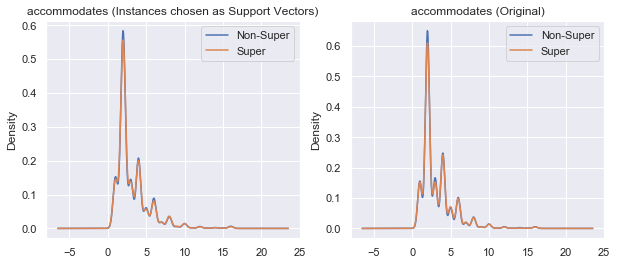

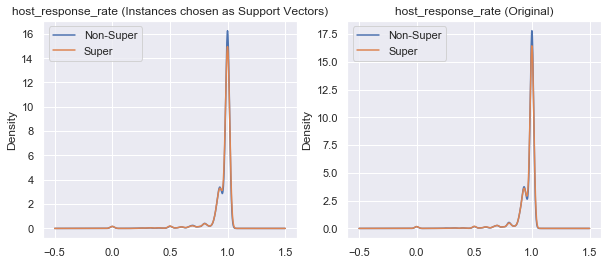

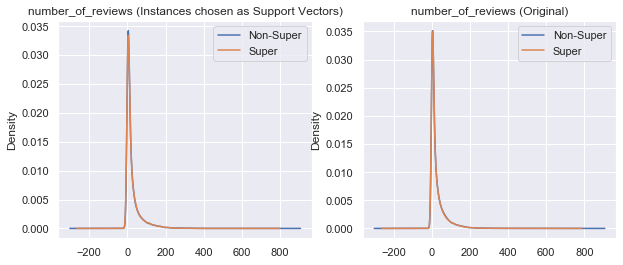

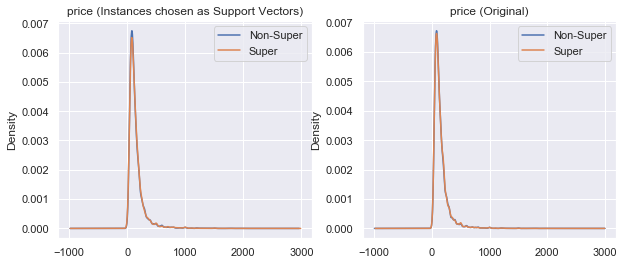

In [76]:
# Visualize statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['superuser'])
df_grouped = df_logistic_dummy.groupby(['superuser'])

# plot KDE of Different variables
vars_to_plot = ['accommodates','host_response_rate','number_of_reviews','price']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Non-Super','Super'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Non-Super','Super'])
    plt.title(v+' (Original)')

Analyzing the figures on the left column, the distributions of the support vector instances do not display distinct separation. This makes sense since the instances typically chosen as support vectors are in close proximity to the class-dividing boundaries and tend to be the instances are are incorrectly classified when training the data. 

However, the distributions of the original data also display poor class separation. This informs us that our data is inadequately classifying our target response variable since the distributions for both classes of our 'superuser' target are almost perfectly overlapped. This can be seen in our prediction accuracies below 60%, and suggests that we need to reconstruct our classification model to predict on another target variable with better class separation. 

Within the context of our target classification of AirBnb Superhosts, the simple distinction of Superhost based on review_score_ratings greater than 0.96 is adequate for the Supoerhost label since our model does a poor job of discerning between the two classes. We may need to consider the other aspects (overall rating, number of stays, cancellation rate, response rate) that influence this designation for our new target variable.

## Model Comparisons: Advantages, Performance, Efficiency

<i>[10 Points]
* Discuss advantages of each model for each classification task
* Does one type of model offer superior performance over another in terms of prediction accuracy?
    * In terms of training time or efficiency? Explain.</i>

In this exercise, logistic regression and support vector machines were used to classify whether a given listing, based off of non-score average attributes, would be labeled a Superuser.

Logistic regression produces weights that can be easily traced back to their original dummy variables. While the magnitudes of these weights were quite low (with an absolute value of 0 to about 0.04), their relative values and signs give some idea as to the relationship of each variable (or level of a variable) with Superuser status. Support vectors do not seem to have the same easy interpretability, especially in a multidimensional space of this order.

Logistic Regression aims to maximize the probability of given data using a logistic function to model the probability of a certain class or outcome. On the other hand, support vector machines aims to produce a hyperplane that maximizes the distances of the points closest to the separation boundary that forms the hyperplane.

Both the logistic regression and support vector machine classification models had comparable prediction accuracies for our given dataset at around 57%. As seen in the scatterplot matrix, the AirBnb data appears to show some degree of linear separation. However, in instances where the data may not be linearly separable, a SVM classifier with a non-linear kernel such as a radial basis function (RBF) should provide superior performance over a logistic regression model in terms of prediction accuracy.

Logistic Regression Classification Models typically offer better efficiency for training time since the computation of the kernels in SVM require a distance between each observation in the dataset. The training process will be become slower with more complicated kernels and larger misclassification penalities (regularization parameter C). 

## APPENDIX

In [77]:
from sklearn.svm import SVC
from sklearn import metrics as mt

# Create SVM training object
svm_clf_rbf = SVC(C = 0.0001, kernel = 'rbf', degree = 3, gamma = 'auto', random_state = 123)
# Train the SVM model
svm_clf_rbf.fit(X_train_scaled, y_train)
# Predict based on trained model - y_hat = model predictions
y_hat = svm_clf_rbf.predict(X_test_scaled)

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('SVM Model Accuracy (Radial Basis Function Kernel)', acc)
print(conf)

SVM Model Accuracy (Radial Basis Function Kernel) 0.575013068478829
[[6600    0]
 [4878    0]]


In [78]:
from sklearn.svm import SVC
from sklearn import metrics as mt

# Create SVM training object
svm_clf_poly = SVC(C = 1.0, kernel = 'poly', degree = 3, gamma = 'auto', random_state = 123)
# Train the SVM model
svm_clf_poly.fit(X_train_scaled, y_train)
# Predict based on trained model - y_hat = model predictions
y_hat = svm_clf_poly.predict(X_test_scaled)

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('SVM Model Accuracy (Polynomial Function Kernel)', acc)
print(conf)

SVM Model Accuracy (Polynomial Function Kernel) 0.569175814601847
[[6313  287]
 [4658  220]]
